# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109B Data Science 2: Advanced Topics in Data Science 
## Homework 1 - Smoothers and Generalized Additive Models



**Harvard University**<br/>
**Spring 2020**<br/>
**Instructors**: Mark Glickman, Pavlos Protopapas, & Chris Tanner


<hr style="height:2pt">

### Homework 1 is due February 6th

In [1]:
#PLEASE RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

### INSTRUCTIONS

- To submit your assignment, please follow the instructions on Canvas.
- Please restart the kernel and run the entire notebook again before you submit.

<hr style="height:2pt">

### Please use the libraries below:

In [2]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.formula.api as sm
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
from pygam import LinearGAM, s, f
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
import statsmodels.api as smo
from statsmodels.api import OLS

# Seaborn visualization library
import seaborn as sns


<hr style="height:2pt">

### Problem 1 - Modeling Seasonality of Airbnb Prices
In this problem, the task is to build a regression model to predict the price of an Airbnb rental for a given date. The data are provided in `calendar_train.csv` and `calendar_test.csv`, which contain availability and price data for a sample of Airbnb units in the Boston area from 2017 to 2018, about 4 observations per day in each set.

Start by loading the data using pandas.  
*Hint*: You likely want to have pandas parse the `date` column as a datetime object via the `parse_dates` argument of `pd.read_csv`

In [3]:
#your code here
train_df = pd.read_csv("./data/calendar_train.csv",parse_dates=['date'])
test_df = pd.read_csv("./data/calendar_test.csv",parse_dates=['date'])

### Exploratory Analysis

Visualize the average price by month and day of the week (i.e., Monday, Tuesday, etc.) for the training set. Point out any trends you notice and explain whether or not they make sense.

In [4]:
train_df=train_df.sort_values(by='date')
train_df['DayOfWeek']=train_df['date'].dt.strftime("%a")
train_df['month']=train_df['date'].dt.strftime("%b")

In [5]:
#checking
min(train_df['date']), max(train_df['date'])

(Timestamp('2017-10-06 00:00:00'), Timestamp('2018-10-05 00:00:00'))

month
Apr    278.442433
Aug    272.628181
Dec    190.547291
Feb    190.617247
Jan    185.940598
Jul    281.397202
Jun    276.534729
Mar    220.600371
May    288.174429
Nov    222.407229
Oct    271.807400
Sep    263.820183
Name: price, dtype: float64


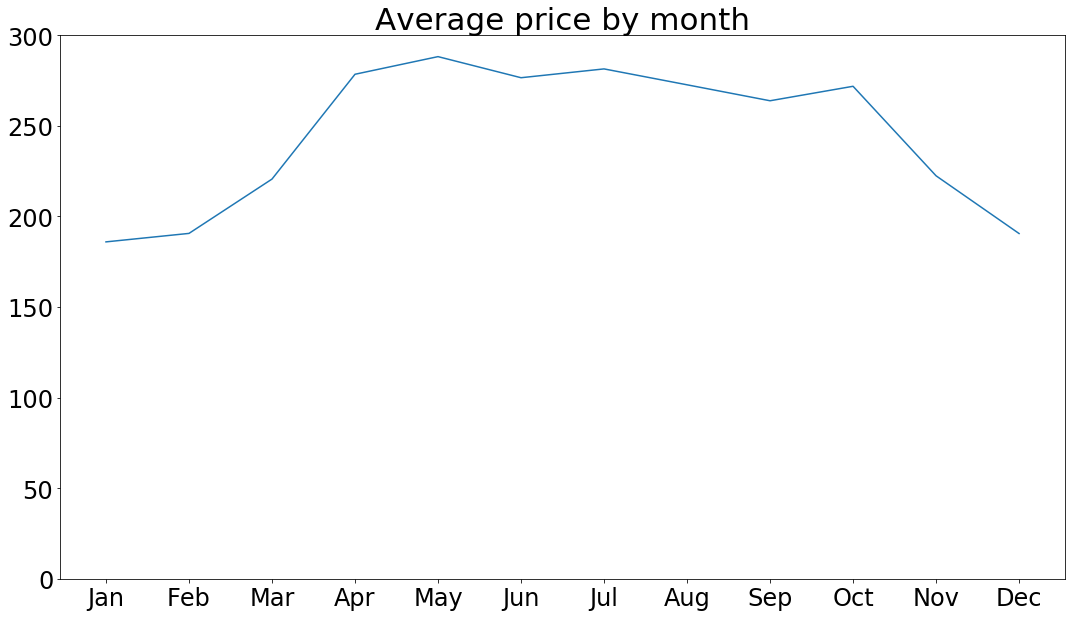

In [6]:
print(train_df.groupby('month').mean()['price'])

#filter database to get into order
month_df = train_df.groupby('month').mean()['price']
month_df = month_df.reindex(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul',
                            'Aug','Sep','Oct','Nov','Dec'])


f, ax = plt.subplots(figsize=(18,10)) # set the size that you'd like (width, height)



plt.plot(month_df.values)
plt.xticks(np.arange(12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul',
                            'Aug','Sep','Oct','Nov','Dec'], fontsize=24)
plt.yticks(fontsize=24)
plt.ylim(0,300)
plt.title("Average price by month",fontsize=31)
plt.show()

DayOfWeek
Fri    247.686228
Mon    235.088040
Sat    249.484869
Sun    237.755570
Thu    237.950429
Tue    233.591537
Wed    230.638254
Name: price, dtype: float64


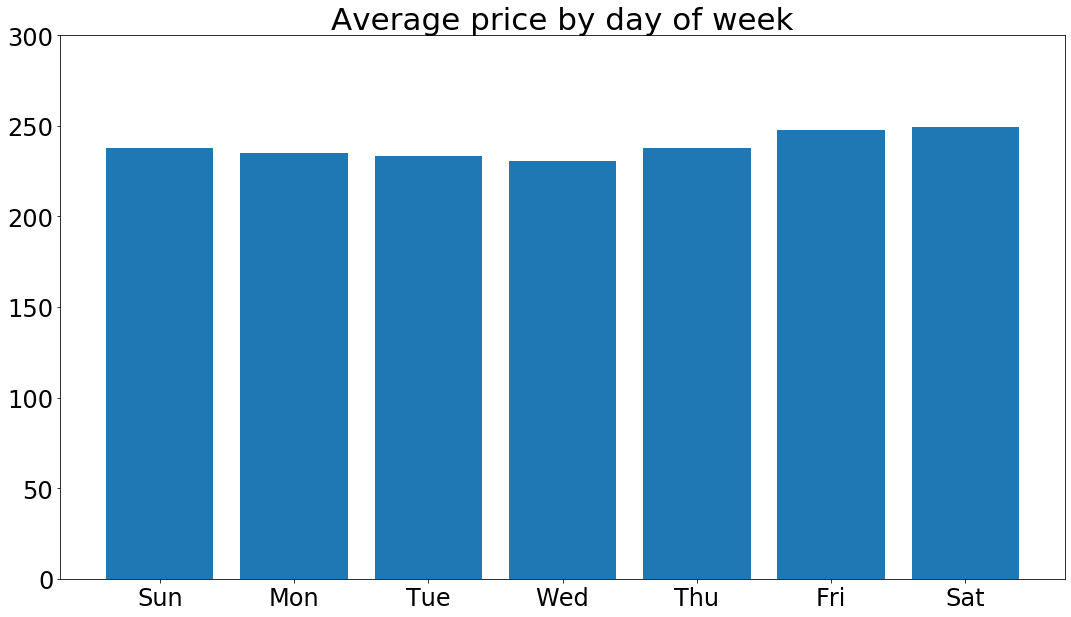

In [7]:
#raw crosstab
print(train_df.groupby('DayOfWeek').mean()['price'])

#filter database to get into order
dayofweek = train_df.groupby('DayOfWeek').mean()['price']
dayofweek = dayofweek.reindex(['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat'])

f, ax = plt.subplots(figsize=(18,10)) # set the size that you'd like (width, height)
ax.bar(['Sun','Mon','Tue','Wed','Thu','Fri','Sat'],dayofweek.values)
plt.xticks(np.arange(7),['Sun','Mon','Tue','Wed','Thu','Fri','Sat'], fontsize=24)
plt.yticks(fontsize=24)
plt.ylim(0,300)
plt.title("Average price by day of week",fontsize=31)
plt.show()


## Answer:
**Month:** There is much more variation by month, which makes sense. Boston is much nicer in the summer, so that would be the time we personally would want to visit. In the winter months, it looks like more people may come for holidays in November, but then there is a sharp dropoff in December, January, and February. April is the beginning of the high season.  

**Day of Week:** In terms of the day of the week, there doesn't appear to be as big of a variation. Tuesday and Wednesday appear to be the cheap days, and Friday & Saturday are the most expensive. This is likely due to increase in demand. 

### Explore different regression models

Fit a regression model that uses the date as a predictor and predicts the price of an Airbnb rental on that date. In this section, you should ignore all other predictors besides the date. Fit the following models on the training set, and compare the $R^2$ of the fitted models on the test set. Include plots of the fitted models for each method.

*Hint*: You may want to convert the `date` column into a numerical variable by taking the difference in days between each date and the earliest date in the column.

1. Fit simple polynomial models of degree 2, 3, 5, and 8 to the training data. Provide train and test R^2 scores and provide plot(s) of a) the daily averages and b) each model's predictions.

2. You should see that the degree 8 polynomial's predictions are awful- either nonsensically near zero [or far too large] at many input values. This isn't just simple overfitting. What is going wrong in this model, and how might it be addressed?

3. Fit a Smoothing spline model in `pygam` with the smoothness parameter chosen by cross-validation on the training set. Provide the train and test scores of the best-performing model, and plot its predictions. Also plot the predictions of models with more and less smoothing. When plotting the smooths, show a scatterplot of the daily averages on the same axes, for context.

4. Of the models, which performs the best? What is the effect of the tuning parameters (degree and smoothness penalty)?

In [8]:
#data cleaning
train_df['new_date']=(train_df['date']-min(train_df['date'])).dt.days #add new date column
test_df['new_date']=(test_df['date']-min(train_df['date'])).dt.days #add new date column

train_df_clean = train_df.dropna() #drop observations with NA price
test_df_clean = test_df.dropna() #drop observations with NA price

len(train_df_clean),len(test_df_clean) #number of observations with full data

(309288, 133100)

### 1. Polynomials

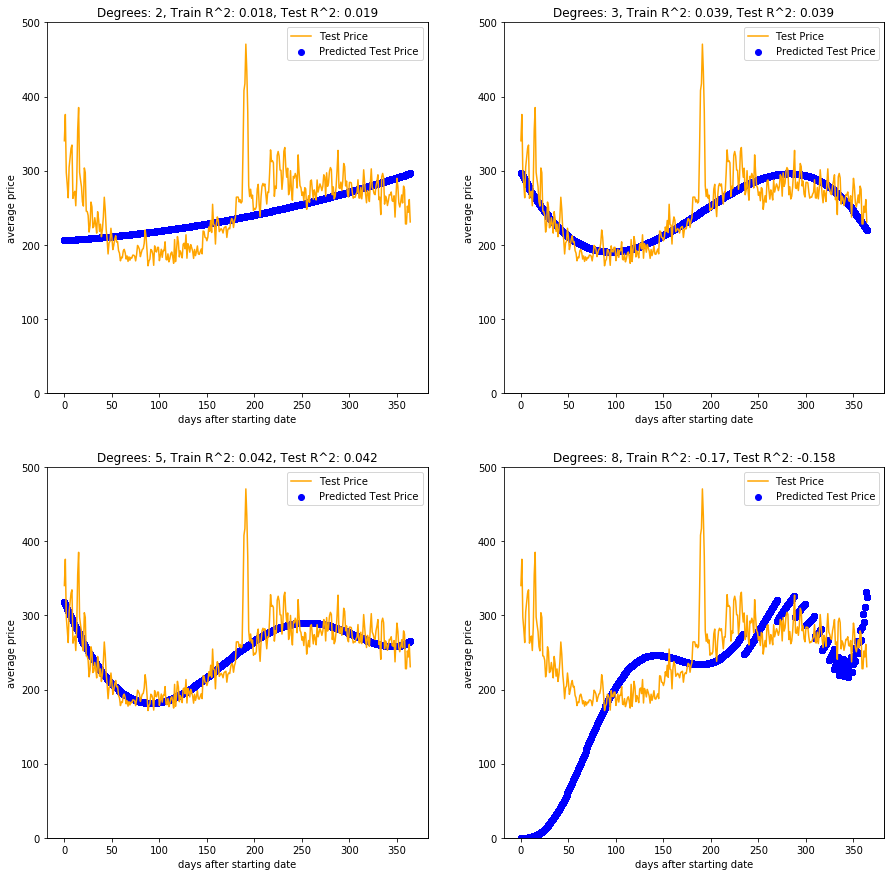

In [9]:
def fit_model(formula, dataframe):
    return sm.ols(formula=formula, data=dataframe).fit()

fig, ax = plt.subplots(2,2,figsize=(15,15))
plt.setp(ax, xticks=[],yticks=[])
z=1

formula = 'price ~ np.vander(new_date, degree+1, increasing=True)-1'

for x in [2,3,5,8]:
    degree=x

    fit2_lm = fit_model(formula, train_df_clean)
    preds = fit2_lm.predict(test_df_clean['new_date'])
    test_r2_score = r2_score(test_df_clean['price'], preds)
    
    ax = fig.add_subplot(2,2,z)
    
    #print(len(test_df_clean))
    ax.scatter(test_df_clean['new_date'],preds, color='blue',label="Predicted Test Price")
    ax.plot((test_df_clean['price'].groupby(test_df_clean['new_date']).mean()),
               color='orange',label="Test Price")
    plt.legend()
    plt.ylim(0,500)
    plt.title("Degrees: "+ str(x)+
             ", Train R^2: "+ str(round(fit2_lm.rsquared,3)) +
              ", Test R^2: "+ str(round(test_r2_score,3)))
    plt.ylabel("average price")
    plt.xlabel("days after starting date")
    z+=1
    
plt.show()
    
    
    

### 2. Degree 8 oddity
On the degree 8 plot, our R squared goes into the negative, suggesting that our model is fairly incoherent. Looking at the graph, it seems that it gets the inflection points completely backwards and has a scattered grouping in the 200-300 day point. We tried a 10-degree polynomial and it gave us something very similar, so we are confused what might be happening. Our best guess is that the model is trying too hard to pick up the huge spike in the middle and some of the other noisiness throughout the data, and at a certain point, it does this to the detriment of predictive power in other spots. 

### 3. Smoothing spline model with the smoothness parameter chosen by cross-validation on the training set.

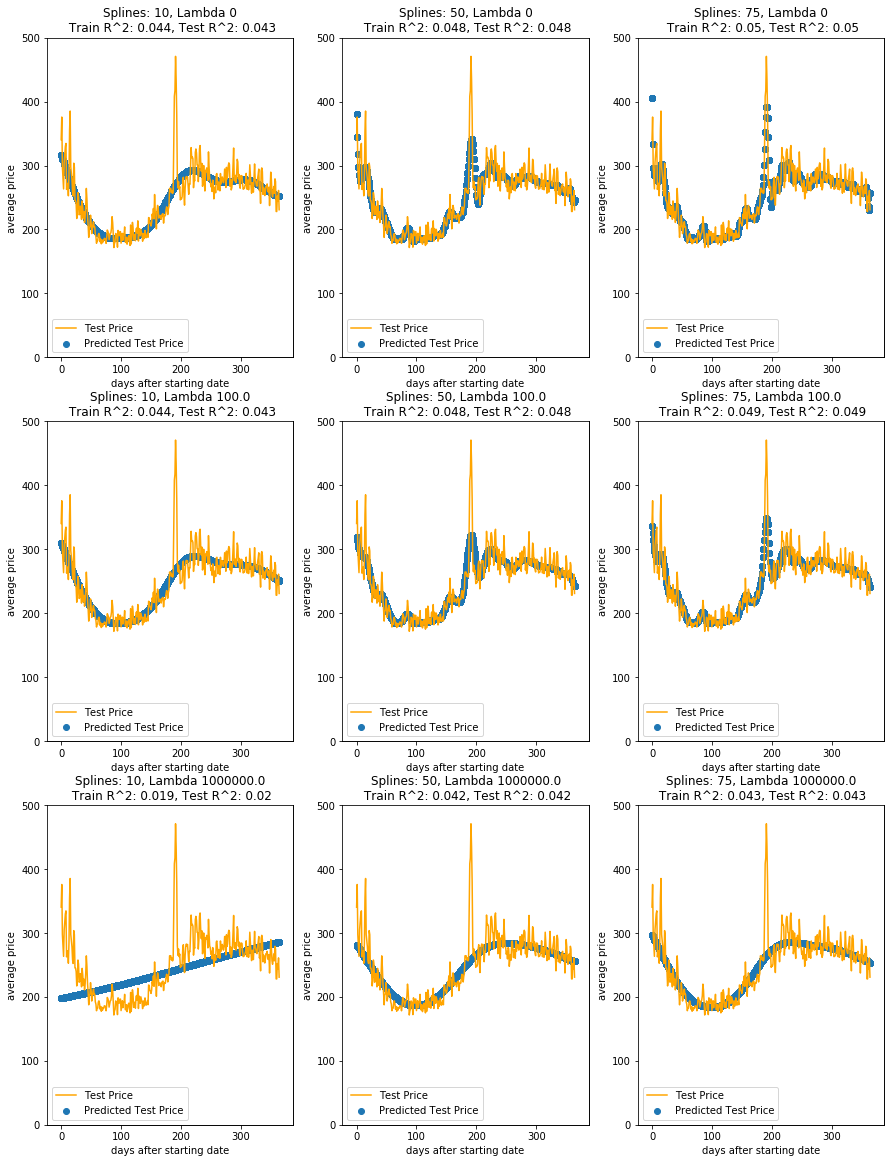

In [10]:
#your code here

fig, ax = plt.subplots(3,3,figsize=(15,20))
plt.setp(ax, xticks=[],yticks=[])
z=1

for y in [0, 1e2, 1e6]:
    for x in [10,50,75]:
        gam = LinearGAM(lam=y, n_splines=x). fit(train_df_clean['new_date'],
                                                  train_df_clean['price'])        
        
        preds = gam.predict(test_df_clean['new_date'])
        train_r2_score = r2_score(train_df_clean['price'],
                                  gam.predict(train_df_clean['new_date']))
        
        test_r2_score = r2_score(test_df_clean['price'], preds)
        
        ax = fig.add_subplot(3,3,z)
        ax.plot((test_df['price'].groupby(test_df['new_date']).mean()),
                       color='orange',label="Test Price")

        ax.scatter(test_df_clean['new_date'], preds,label = "Predicted Test Price")

        plt.legend()
        plt.ylim(0,500)
        plt.title("Splines: "+ str(x) + ", Lambda " + str(y) +
              "\n Train R^2: "+ str(round(train_r2_score,3)) +
              ", Test R^2: "+ str(round(test_r2_score,3)))

        plt.ylabel("average price")
        plt.xlabel("days after starting date")
        z+=1
        
plt.show()


### 4. Effects of parameters
Of the models, which performs the best? What is the effect of the tuning parameters (degree and smoothness penalty)?

**Best Model:** The tuning parameter appears to limit the variance of the predicted output. When we set the lambda to 1,000,000 it essentially created a linear output. This was the worst performing model. More splines allowed the model to hit some of the high variation points, especially that major spike in the middle. Our best performing model had no tuning parameter and the highest spline at 75. We think we might get more predictive power with more splines, before we start overfitting. 

### Part 1b: Adapting to weekends

It is possible/likely that prices on weekends (Friday nights and Saturday nights) are systematically higher than prices on weekdays, and that including this aspect of the data-generating process in our model will produce a better fit.

5. Create a binary indicator of weekend versus non-weekend, and include it in your best-performing model from above. How does it impact the model's performance?  
*Hint*: include a categorical variable in a GAM by importing and using `pygam.f` in the same way you've used `pygam.s` for continuous variables.


In [11]:
train_df_clean['weekend'] = train_df_clean.DayOfWeek.apply(lambda x: 1 if x in['Fri','Sat'] else 0) #code from https://cmdlinetips.com/2019/05/how-to-create-a-column-using-condition-on-another-column-in-pandas/


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [12]:
test_df_clean['DayOfWeek']=test_df['date'].dt.strftime("%a")
test_df_clean['weekend'] = test_df_clean.DayOfWeek.apply(lambda x: 1 if x in['Fri','Sat'] else 0)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [13]:
#Fit
X_train = train_df_clean[['new_date','weekend']]
y_train = train_df_clean['price']
X_test = test_df_clean[['new_date','weekend']]
y_test = test_df_clean['price']

gam = LinearGAM(lam=0, n_splines=75).fit(X_train,y_train)

#R-squared
train_r2_score = r2_score(y_train,
                    gam.predict(X_train))
test_r2_score = r2_score(y_test, gam.predict(X_test))

print("Train R2:", train_r2_score)
print('Test R2:', test_r2_score)

Train R2: 0.050991958921397296
Test R2: 0.051324432394749264


**How does it impact the model's performance?**

Our model performs better than the original model on both the test and training dataset.

### Part 1c: Going the Distance

You may have noticed from your scatterplots of average price versus day on the training set that there are a few days with abnormally high average prices.

Sort the training data in decreasing order of average price, extracting the 10 most expensive dates. Why are the prices on these days so high? Is it something about the days themselves, noise, an artifact of data collection, or something else?

In [14]:
train_df.groupby('date').mean()['price'].sort_values(ascending = False).head(10)

date
2018-04-14    432.680761
2018-04-16    425.289528
2018-04-15    417.170404
2017-10-07    409.298701
2018-04-13    393.609047
2017-10-21    381.526515
2017-10-20    374.955932
2017-10-06    370.173410
2018-04-17    369.371060
2017-10-13    351.800725
Name: price, dtype: float64

In [15]:
expensive_dates = train_df.groupby('date').mean()['price'].sort_values(ascending = False).head(10)

In [16]:
expensive_dates_df =  train_df_clean.loc[train_df_clean['date'].isin(expensive_dates.index)]
expensive_dates_df

,listing_id,date,available,price,DayOfWeek,month,new_date,weekend
10207,10116095,2017-10-06,t,119.0,Fri,Oct,0,1
659238,586994,2017-10-06,t,185.0,Fri,Oct,0,1
290785,4624582,2017-10-06,t,40.0,Fri,Oct,0,1
176367,9133440,2017-10-06,t,499.0,Fri,Oct,0,1
614222,82637,2017-10-06,t,175.0,Fri,Oct,0,1
...,...,...,...,...,...,...,...,...
93725,4233242,2018-04-17,t,109.0,Tue,Apr,193,0
181300,15268842,2018-04-17,t,1120.0,Tue,Apr,193,0
135158,19455477,2018-04-17,t,697.0,Tue,Apr,193,0
321998,990668,2018-04-17,t,337.0,Tue,Apr,193,0


In [17]:
expensive_dates_df.groupby('DayOfWeek').count().listing_id

DayOfWeek
Fri    1363
Mon     487
Sat     891
Sun     446
Tue     698
Name: listing_id, dtype: int64

The ones in April could probably be explained by Easter. There is also a group of dates in October which could be related to events in Boston that year. People might like traveling to Boston to see the fall foliage and tour the Harvard campus. 

### Problem 2: Predicting Airbnb Rental Price Through Listing Features

In this problem, we'll continue our exploration of Airbnb data by predicting price based on listing features. The data can be found in `listings_train.csv` and `listings_test.csv`.

First, visualize the relationship between each of the predictors and the response variable. Does it appear that some of the predictors have a nonlinear relationship with the response variable?

In [18]:
#your code here
listings_train = pd.read_csv("./data/listings_train.csv")
listings_test = pd.read_csv("./data/listings_test.csv")

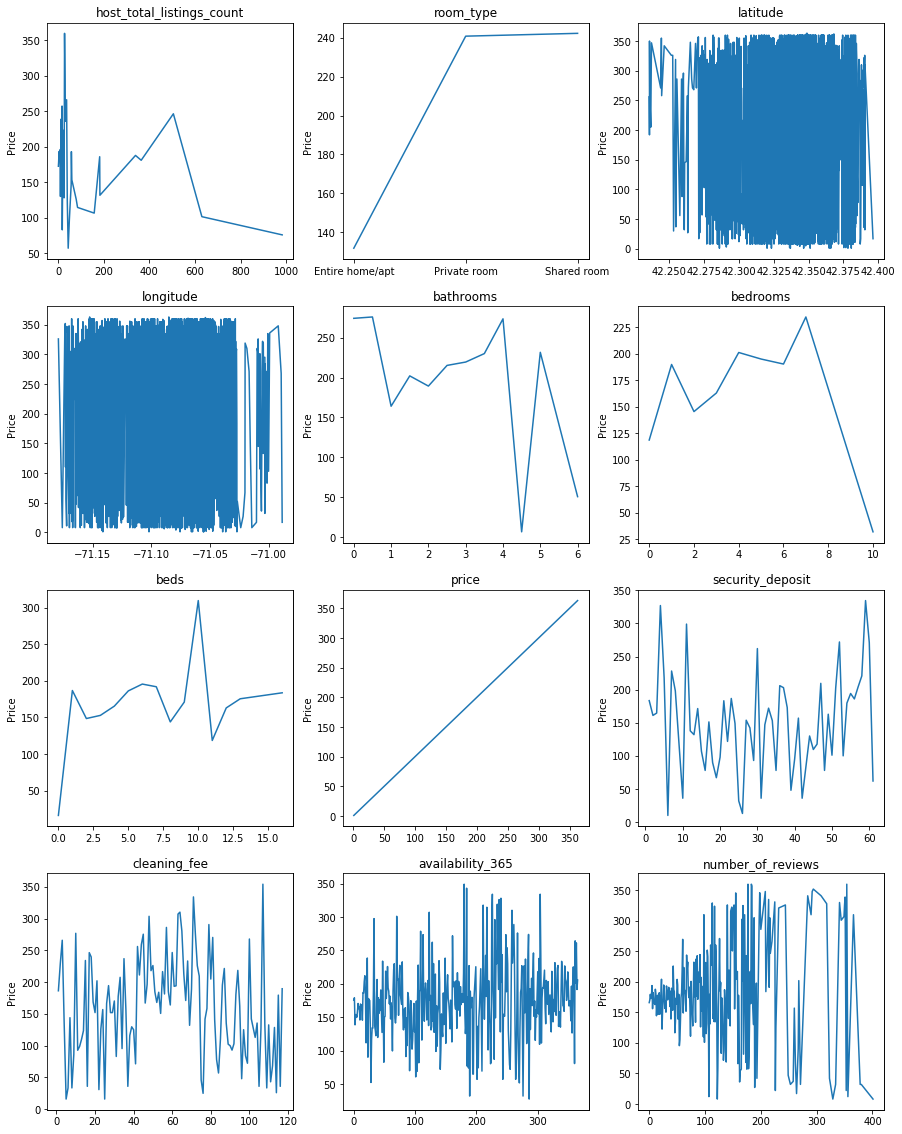

In [19]:
#fig, ax = plt.subplots(12, figsize=(16,70))

fig, ax = plt.subplots(4,3,figsize=(15,20))
plt.setp(ax, xticks=[],yticks=[])

z=1
for i in listings_train.columns:
  
    ax = fig.add_subplot(4,3,z)
    ax.plot(listings_train['price'].groupby(listings_train[i]).mean())
    plt.title(i)
    ax.set_ylabel('Price')
    z+=1

#fig.set_title("Bivariate relationships with price");

All of the variables that show a relationship seem to be nonlinear. These are: bathrooms, bedrooms, beds, room_type and listings count.

### Part 2a: Polynomial Regression

Fit the following models on the training set and compare the $R^2$ score of the fitted models on the test set:
    
* Linear regression
* Regression with polynomial basis functions of degree 3 (i.e., basis functions $x$, $x^2$, $x^3$ for each predictor $x$) for quantitative predictors.

In [20]:
X_train = listings_train.copy()
X_test = listings_test.copy()
y_test = X_test['price']
y_train = X_train['price']


del X_train['price']
del X_test['price'] 

In [21]:
X_train['room_type_private_room'] = 1*(X_train["room_type"] == "Private room")
X_train['room_type_Entire_home/apt'] = 1*(X_train["room_type"] == "Entire home/apt")
del X_train['room_type']

X_test['room_type_private_room'] = 1*(X_test["room_type"] == "Private room")
X_test['room_type_Entire_home/apt'] = 1*(X_test["room_type"] == "Entire home/apt")
del X_test['room_type']

In [22]:
#reshape ys into numpy vector
y_train_arr = np.asarray(y_train).reshape(y_train.shape[0], 1)
y_test_arr  = np.asarray(y_test).reshape(y_test.shape[0], 1)
print(y_train_arr .shape)
print(y_test_arr .shape)

(4370, 1)
(487, 1)


In [23]:
# part of the code was taken from cs109A
# create the X matrix by appending a column of ones to x_train
X_train_arr  = np.asarray(smo.add_constant(X_train))
X_test_arr  = np.asarray(smo.add_constant(X_test))

# build the OLS model (ordinary least squares) from the training data
airbnb_lm = smo.OLS(y_train_arr , X_train)

# do the fit and save regression info (parameters, etc) in OLSModel
OLSModel = airbnb_lm.fit()

predictions_tr = OLSModel.predict(X_train) 
predictions_te = OLSModel.predict(X_test) 

r2_tr = (r2_score(y_train_arr , predictions_tr))
r2_te = (r2_score(y_test_arr , predictions_te))

print(f'the r-squared of the model on the training set is {r2_tr}')
print(f'the r-squared of the model on the test set is {r2_te}')

the r-squared of the model on the training set is 0.24923262455121742
the r-squared of the model on the test set is 0.18257404894906415


/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [24]:
# Polynomial regression
#Some code taken from lab 2 and https://stackoverflow.com/questions/54891965/multivariate-polynomial-regression-with-python

In [25]:
X_train_q = X_train.copy()
del X_train_q['room_type_private_room']
del X_train_q['room_type_Entire_home/apt']

X_test_q = X_test.copy()
del X_test_q['room_type_private_room']
del X_test_q['room_type_Entire_home/apt']

In [26]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model

poly = PolynomialFeatures(degree=3)
poly_var_train = poly.fit_transform(X_train_q)
poly_var_test = poly.fit_transform(X_test_q)

regression = linear_model.LinearRegression()

model = regression.fit(poly_var_train, y_train)
R2_score_train  = model.score(poly_var_train, y_train)
R2_score_test = model.score(poly_var_test, y_test)

print(f'the r-squared of the model on the training set is {R2_score_train}')
print(f'the r-squared of the model on the test set is {R2_score_test}')

the r-squared of the model on the training set is 0.23782994759654552
the r-squared of the model on the test set is 0.07035932071724926


### Part 2b: Generalized Additive Model (GAM)

1. Do you see any advantage in fitting an additive regression model to these data, compared to the above models?

1. Fit a GAM to the training set, and compare the test $R^2$ of the fitted model to the above models. You may use a smoothing spline basis function on each predictor, with the same smoothing parameter for each basis function, tuned using cross-validation on the training set.

2. Plot and examine the smooth of each predictor for the fitted GAM. What are some useful insights conveyed by these plots?


Yes, the discontinuities in the bivariate relationships suggest that the flexibility added by the GAMs could potentially improve the accuracy of the model.


In [27]:
from pygam import LinearGAM, s, f
from sklearn.preprocessing import LabelEncoder

gam = LinearGAM().fit(X_train,y_train)
gam.gridsearch(X_train, y_train)
gam.summary()

100% (11 of 11) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                       32.45
Link Function:                     IdentityLink Log Likelihood:                                -44133.9073
Number of Samples:                         4370 AIC:                                            88334.7146
                                                AICc:                                           88335.2462
                                                GCV:                                             9835.4646
                                                Scale:                                             9704.09
                                                Pseudo R-Squared:                                   0.2711
Feature Function                  Lam

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  


In [28]:
preds = gam.predict(X_test)
train_r2_score = r2_score(y_train, gam.predict(X_train))
print("R-squared train:", train_r2_score)
test_r2_score = r2_score(y_test, preds)
print("R-squared test:", test_r2_score)

R-squared train: 0.27107642973182455
R-squared test: 0.22703178573998495


<Figure size 432x288 with 0 Axes>

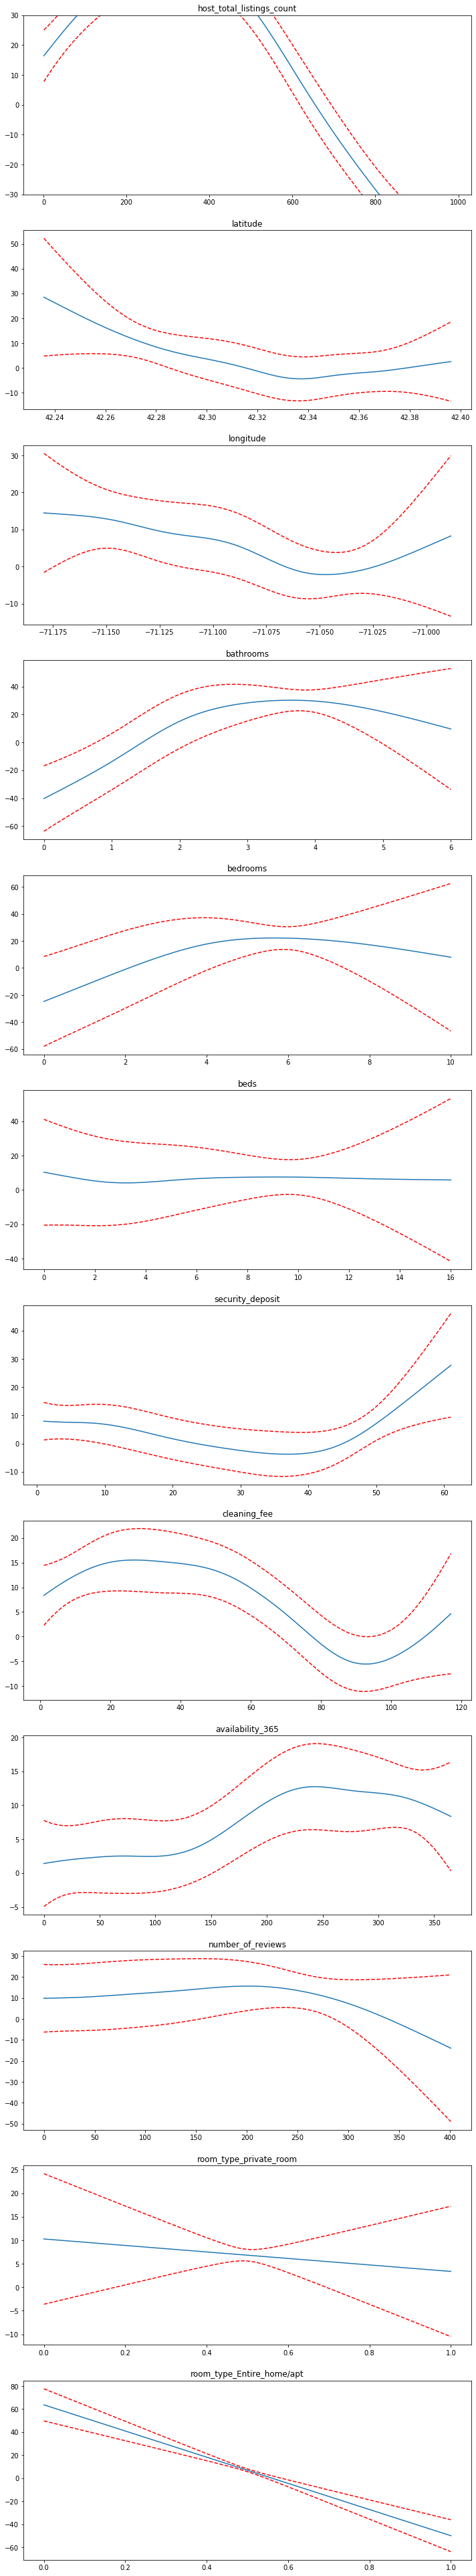

In [32]:
#Code from lab
plt.figure();
fig, axs = plt.subplots(12,1, figsize=(12,70));

titles = X_test.columns
for i, ax in enumerate(axs):
    XX = gam.generate_X_grid(term=i)
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX))
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX, width=.95)[1], c='r', ls='--')
    if i == 0:
        ax.set_ylim(-30,30)
    ax.set_title(titles[i]);

### Part 2c: Putting it All Together
Using the GAM outputs and insights from part 1), discuss the most important variables in the driving prices, and give advide to a frugal traveller hoping to visit Boston.

The results in part 1 suggest that travelling on weekdays and during the winter might help them get cheaper prices. The GAM outputs suggest that the amount of bathrooms, the amount of listings of the owner, the cleaning fee, the availability and the type of room are the most important variables driving prices.